# Определение наличия товаров на полке

## Описание проекта
Необходимо решить задачу бинарной классификации – определение наличия товаров на полке в интервалах без продаж с оценкой производительности по метрике AUC-ROC.
<ul>
<li>Направление 1: Построить модель без использования оценки вероятности отсутствия товара на полке, представленной в витрине данных.</li>
<li>Направление 2: Построить модель с использованием оценки вероятности отсутствия товара на полке как один из признаков.</li>
</ul>

Наиболее перспективные решения финалистов будут участвовать в боевом АВ-тестировании в магазинах сети Дикси!

## Описание данных
**Признаки**

- LocationId - уникальный идентификатор магазина
- ProductId - уникальный идентификатор товара
- ValidationDateTime - дата и время в формате гггг-мм-дд чч:мм:сс
- Probability -
- Column6 - Column67 - это анонимизированные данные, скрытые заказчиком.

**Целевой признак**

- IsCorrect - наличие или отсутствие товара на полке: 0 - товар имеется на полке, 1 - товара на полке нет.

По смыслу, IsCorrect = 0 означает, что сигнал был некорректным (дали такой товар на проверку сотрудникам магазина, но с ценником и с товаром все ок).

IsCorrect = 1 включает в себя и проблему с выкладкой, и проблему с ценником (то есть товар не продавался по какой-то из этих причин).

## Загрузка библиотек

In [ ]:
! pip install -q catboost

In [ ]:
import pandas as pd
import numpy as np

from tqdm import tqdm

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from plotly.subplots import make_subplots

# ML
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

# Настройки
# Убираем ограничение отображемых колонок
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')

# Загрузка файлов с диска
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

# Константы
RANDOM = 12345

Mounted at /content/drive


## Загрузка и изучение данных

In [ ]:
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Хакатоны/GoodsForecastHack/Features.xlsx')

In [ ]:
display(df.head(), df.tail())

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07.000,0.416474,0.0,86,85,0.011628,NaN,NaN,0.142857,2,NaN,14.990,14.990,0.0,0.0,1.0,1,NaN,-1.0,NaN,142.0,19,28,NaN,1.367042,NaN,0.047139,14.99000,14.99000,14.99,14.990,0.000000,1.000000,116.0,1738.84,14.990,14.99,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.0,14.990,14.990,14.990,14.990,14.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
1,63,288606,2023-06-01 15:32:31.000,0.687710,0.0,8,7,0.125000,NaN,NaN,3.714286,19,NaN,29.990,29.990,0.0,0.0,1.0,0,4.0,3.0,1.0,15.0,19,28,NaN,6.573534,0.931034,0.226674,29.85486,29.94110,29.99,27.390,0.086696,0.415254,20060.0,600618.50,29.990,29.99,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,1.0,1.0,0.0,1.0,-1.0,0.0,29.990,29.990,29.990,29.990,29.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
2,63,288606,2023-06-03 12:55:49.000,0.810383,0.0,10,9,0.100000,NaN,NaN,3.214286,19,NaN,29.990,29.990,0.0,0.0,1.0,0,6.0,5.0,1.0,11.0,16,25,NaN,5.946440,0.923077,0.228709,29.84843,29.93755,29.99,27.390,0.086696,0.445454,18700.0,559832.10,29.990,29.99,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,1.0,1.0,0.0,1.0,-1.0,0.0,29.990,29.990,29.990,29.990,29.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
3,63,288606,2023-06-07 14:57:38.000,0.312500,0.0,4,3,0.250000,NaN,NaN,3.178571,19,NaN,24.575,24.575,0.0,0.0,0.0,1,NaN,-1.0,NaN,22.0,8,17,NaN,2.684130,NaN,0.149118,29.60873,29.83191,29.99,24.575,0.180560,0.609524,17850.0,532499.50,24.575,27.39,-2.814999,-0.114547,1.805602e-01,8.669563e-02,0.093865,1.0,1.0,0.0,1.0,1.0,0.0,1.0,24.575,24.575,24.575,24.575,24.575,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
4,63,288606,2023-06-09 14:56:35.000,0.605429,0.0,6,5,0.166667,NaN,NaN,3.035714,19,NaN,29.990,29.990,0.0,0.0,0.0,1,NaN,-1.0,NaN,18.0,18,27,NaN,4.700637,NaN,0.167880,29.20400,29.66586,29.99,20.300,0.323108,0.630631,18870.0,559794.70,29.990,29.99,0.000000,0.000000,6.359949e-08,6.359949e-08,0.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,29.990,29.990,29.990,29.990,29.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0


,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
176613,2950,576631,2023-07-12 15:17:30.000,0.542776,1.0,1,0,1.000000,NaN,NaN,4.285714,27,NaN,119.9000,119.9000,0.0,0.0,0.0,1,NaN,-1.0,NaN,78.0,8,16,NaN,2.380474,NaN,0.140028,119.7558,119.7549,119.9000,119.05,0.007089,0.669291,18288.0,2190077.0,119.9000,119.8967,0.003334,0.000028,0.000000,0.000028,-0.000028,1.0,0.0,1.0,1.0,0.0,1.0,0.0,119.9000,119.9000,119.9000,119.9000,119.9000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176614,2950,576631,2023-07-15 15:02:34.000,0.497054,1.0,4,4,0.000000,NaN,NaN,4.071429,27,NaN,119.9000,119.9000,0.0,0.0,0.0,1,NaN,0.0,NaN,64.0,7,6,NaN,1.596193,NaN,0.228027,119.7819,119.8833,124.3871,116.08,0.066785,0.695652,19872.0,2382322.0,119.9000,119.6000,0.300003,0.002502,0.036074,0.038486,-0.002412,1.0,0.0,1.0,1.0,0.0,1.0,0.0,119.9000,119.9000,119.9000,119.9000,119.9000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176615,2950,576631,2023-07-26 15:01:27.000,0.930926,NaN,1,0,1.000000,NaN,NaN,3.571429,28,NaN,139.9000,139.9000,0.0,0.0,0.0,1,NaN,-1.0,NaN,123.0,12,20,NaN,2.759440,NaN,0.131402,126.0216,123.9945,139.9000,116.08,0.170264,0.622047,18288.0,2267611.0,139.9000,139.5920,0.307999,0.002202,0.000000,0.002202,-0.002202,1.0,0.0,1.0,1.0,0.0,1.0,0.0,139.9000,139.9000,139.9000,139.9000,139.9000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176616,2950,576631,2023-07-28 15:04:19.000,0.704421,NaN,3,2,0.333333,NaN,NaN,3.607143,28,NaN,139.6850,139.6850,0.0,0.0,0.0,1,NaN,-1.0,NaN,118.0,8,16,NaN,2.238112,NaN,0.131654,127.2789,125.1582,139.9000,116.08,0.170264,0.610170,16992.0,2126689.0,139.6850,139.9000,-0.214996,-0.001539,0.001537,0.000000,0.001537,1.0,0.0,1.0,1.0,0.0,1.0,0.0,139.6850,139.6850,139.6850,139.6850,139.6850,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176617,2950,576631,2023-07-31 15:06:58.000,0.502083,NaN,6,6,0.000000,NaN,NaN,3.857143,28,NaN,139.7325,139.7325,0.0,0.0,0.0,0,1.0,1.0,1.0,98.0,7,6,NaN,1.832809,3.285714,0.261830,129.1424,128.2955,139.9000,116.08,0.170264,0.603175,18144.0,2327793.0,139.7325,139.7000,0.032501,0.000233,0.001197,0.001430,-0.000232,0.0,0.0,0.0,0.0,0.0,0.0,1.0,139.7325,139.7325,139.7325,139.7325,139.7325,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176618 entries, 0 to 176617
Data columns (total 66 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   LocationId          176618 non-null  int64  
 1   ProductId           176618 non-null  int64  
 2   ValidationDateTime  176618 non-null  object 
 3   Probability         176305 non-null  float64
 4   IsCorrect           135847 non-null  float64
 5   Column6             176618 non-null  int64  
 6   Column7             176618 non-null  int64  
 7   Column8             141486 non-null  float64
 8   Column9             0 non-null       float64
 9   Column10            0 non-null       float64
 10  Column11            176618 non-null  float64
 11  Column12            176618 non-null  int64  
 12  Column13            45863 non-null   float64
 13  Column14            176617 non-null  float64
 14  Column15            176583 non-null  float64
 15  Column16            176583 non-nul

In [ ]:
gaps_in_the_data = pd.DataFrame({'percent_of_nulls':df.isnull().sum()/len(df)})
gaps_in_the_data['percent_of_nulls'] = gaps_in_the_data['percent_of_nulls'].map(lambda x: '{:.2%}'.format(x))

gaps_in_the_data.sort_values(by='percent_of_nulls', ascending=False)

,percent_of_nulls
Column13,74.03%
Column22,68.70%
Column20,68.70%
Column28,49.44%
IsCorrect,23.08%
Column8,19.89%
Column21,19.17%
Column26,100.00%
Column66,100.00%
Column9,100.00%


In [ ]:
values = df['IsCorrect'].value_counts()
values = values.to_frame().reset_index()
values.columns = ['Boolean', 'Count']
values['Percentage'] = df['IsCorrect'].value_counts(normalize=True)
pd.DataFrame(values)
values

,Boolean,Count,Percentage
0,0.0,104657,0.770403
1,1.0,31190,0.229597


In [ ]:
def visualize_class_balance(x, y, values, labels):

    '''

    Функция для визуализации баланса классов (в абсолютных величинах и в процентах).

    '''

    fig = make_subplots(rows = 1, cols = 2,
                    specs = [[{"type": "bar"}, {"type": "pie"}]],
                    subplot_titles = ('Доля товаров, в зависимости от класса',
                                    'Доля товаров, в зависимости от класса'))

    fig.add_trace(go.Bar(x = x, y = y), row = 1, col = 1)
    fig.add_trace(go.Pie(values = values, labels = labels), row = 1, col = 2)

    fig.update_layout(height = 400, showlegend = False, title_font_size=22, title_text = "Факт наличия или отсутствия товара на полке: 0 - товар имеется на полке, 1 - товара на полке нет.")
    fig.show()

visualize_class_balance(values['Boolean'], values['Count'], values['Percentage'], values['Boolean'])

> В выборке представлены товары, где 77% товаров присутствуют на полке, а 23% - отсутствуют, что говорит нам о том, что данные довольно несбалансированы. И целевой признак IsCorrect распределён в сооотношении 3,5:1.

## Предобработка данных
Данные сырые, поэтому необходима предобработка:
<ol>
<li>Добавим новые временные признаки: месяц, неделя, дата, день недели, час, минуты.</li>
<li>Обработка пропусков: удалим все признаки, доля пропусков в которых больше 35%.</li>
</ol>

In [ ]:
model_feats = ['LocationId', 'ProductId']

def parse_date(df):
    df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])
    df['month'] = df['ValidationDateTime'].dt.month
    df['week'] = df['ValidationDateTime'].dt.isocalendar().week
    df['day'] = df['ValidationDateTime'].dt.day
    df['day_of_week'] = df['ValidationDateTime'].dt.day_of_week
    df['hour'] = df['ValidationDateTime'].dt.hour
    df['minute'] = df['ValidationDateTime'].dt.minute

def extract_feats(df_base):
    df = df_base.copy()
    parse_date(df)

    df = df.sort_values(['LocationId', 'ProductId', 'ValidationDateTime'])

    for i in tqdm(range(1, 3)):
        df[f'shift_prob_{i}'] = df.groupby(['LocationId', 'ProductId'])['Probability'].shift(i)

    df[model_feats] = df[model_feats].astype('category')
    float_feats = df.columns.difference(model_feats + ['ValidationDateTime', 'IsCorrect'])
    df[float_feats] = df[float_feats].astype(float)

    thresh_nan = 0.65
    drop_feats = df.columns[df.isna().mean()>=thresh_nan].to_list()
    df = df.drop(drop_feats, axis=1)
    return df

In [ ]:
data = extract_feats(df)

100%|██████████| 2/2 [00:00<00:00, 33.47it/s]


In [ ]:
display(data.head(), data.tail())

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column14,Column15,Column16,Column17,Column18,Column19,Column21,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67,month,week,day,day_of_week,hour,minute,shift_prob_1,shift_prob_2
0,63,288527,2023-06-28 14:57:07,0.416474,0.0,86.0,85.0,0.011628,0.142857,2.0,14.990,14.990,0.0,0.0,1.0,1.0,-1.0,142.0,19.0,28.0,1.367042,NaN,0.047139,14.99000,14.99000,14.99,14.990,0.000000,1.000000,116.0,1738.84,14.990,14.99,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.0,14.990,14.990,14.990,14.990,14.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,26.0,28.0,2.0,14.0,57.0,NaN,NaN
1,63,288606,2023-06-01 15:32:31,0.687710,0.0,8.0,7.0,0.125000,3.714286,19.0,29.990,29.990,0.0,0.0,1.0,0.0,3.0,15.0,19.0,28.0,6.573534,0.931034,0.226674,29.85486,29.94110,29.99,27.390,0.086696,0.415254,20060.0,600618.50,29.990,29.99,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,1.0,1.0,0.0,1.0,-1.0,0.0,29.990,29.990,29.990,29.990,29.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,22.0,1.0,3.0,15.0,32.0,NaN,NaN
2,63,288606,2023-06-03 12:55:49,0.810383,0.0,10.0,9.0,0.100000,3.214286,19.0,29.990,29.990,0.0,0.0,1.0,0.0,5.0,11.0,16.0,25.0,5.946440,0.923077,0.228709,29.84843,29.93755,29.99,27.390,0.086696,0.445454,18700.0,559832.10,29.990,29.99,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,1.0,1.0,0.0,1.0,-1.0,0.0,29.990,29.990,29.990,29.990,29.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,22.0,3.0,5.0,12.0,55.0,0.687710,NaN
3,63,288606,2023-06-07 14:57:38,0.312500,0.0,4.0,3.0,0.250000,3.178571,19.0,24.575,24.575,0.0,0.0,0.0,1.0,-1.0,22.0,8.0,17.0,2.684130,NaN,0.149118,29.60873,29.83191,29.99,24.575,0.180560,0.609524,17850.0,532499.50,24.575,27.39,-2.814999,-0.114547,1.805602e-01,8.669563e-02,0.093865,1.0,1.0,0.0,1.0,1.0,0.0,1.0,24.575,24.575,24.575,24.575,24.575,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,23.0,7.0,2.0,14.0,57.0,0.810383,0.687710
4,63,288606,2023-06-09 14:56:35,0.605429,0.0,6.0,5.0,0.166667,3.035714,19.0,29.990,29.990,0.0,0.0,0.0,1.0,-1.0,18.0,18.0,27.0,4.700637,NaN,0.167880,29.20400,29.66586,29.99,20.300,0.323108,0.630631,18870.0,559794.70,29.990,29.99,0.000000,0.000000,6.359949e-08,6.359949e-08,0.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,29.990,29.990,29.990,29.990,29.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,23.0,9.0,4.0,14.0,56.0,0.312500,0.810383


,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column14,Column15,Column16,Column17,Column18,Column19,Column21,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67,month,week,day,day_of_week,hour,minute,shift_prob_1,shift_prob_2
176613,2950,576631,2023-07-12 15:17:30,0.542776,1.0,1.0,0.0,1.000000,4.285714,27.0,119.9000,119.9000,0.0,0.0,0.0,1.0,-1.0,78.0,8.0,16.0,2.380474,NaN,0.140028,119.7558,119.7549,119.9000,119.05,0.007089,0.669291,18288.0,2190077.0,119.9000,119.8967,0.003334,0.000028,0.000000,0.000028,-0.000028,1.0,0.0,1.0,1.0,0.0,1.0,0.0,119.9000,119.9000,119.9000,119.9000,119.9000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,12.0,2.0,15.0,17.0,NaN,NaN
176614,2950,576631,2023-07-15 15:02:34,0.497054,1.0,4.0,4.0,0.000000,4.071429,27.0,119.9000,119.9000,0.0,0.0,0.0,1.0,0.0,64.0,7.0,6.0,1.596193,NaN,0.228027,119.7819,119.8833,124.3871,116.08,0.066785,0.695652,19872.0,2382322.0,119.9000,119.6000,0.300003,0.002502,0.036074,0.038486,-0.002412,1.0,0.0,1.0,1.0,0.0,1.0,0.0,119.9000,119.9000,119.9000,119.9000,119.9000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,15.0,5.0,15.0,2.0,0.542776,NaN
176615,2950,576631,2023-07-26 15:01:27,0.930926,NaN,1.0,0.0,1.000000,3.571429,28.0,139.9000,139.9000,0.0,0.0,0.0,1.0,-1.0,123.0,12.0,20.0,2.759440,NaN,0.131402,126.0216,123.9945,139.9000,116.08,0.170264,0.622047,18288.0,2267611.0,139.9000,139.5920,0.307999,0.002202,0.000000,0.002202,-0.002202,1.0,0.0,1.0,1.0,0.0,1.0,0.0,139.9000,139.9000,139.9000,139.9000,139.9000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,30.0,26.0,2.0,15.0,1.0,0.497054,0.542776
176616,2950,576631,2023-07-28 15:04:19,0.704421,NaN,3.0,2.0,0.333333,3.607143,28.0,139.6850,139.6850,0.0,0.0,0.0,1.0,-1.0,118.0,8.0,16.0,2.238112,NaN,0.131654,127.2789,125.1582,139.9000,116.08,0.170264,0.610170,16992.0,2126689.0,139.6850,139.9000,-0.214996,-0.001539,0.001537,0.000000,0.001537,1.0,0.0,1.0,1.0,0.0,1.0,0.0,139.6850,139.6850,139.6850,139.6850,139.6850,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,30.0,28.0,4.0,15.0,4.0,0.930926,0.497054
176617,2950,576631,2023-07-31 15:06:58,0.502083,NaN,6.0,6.0,0.000000,3.857143,28.0,139.7325,139.7325,0.0,0.0,0.0,0.0,1.0,98.0,7.0,6.0,1.832809,3.285714,0.261830,129.1424,128.2955,139.9000,116.08,0.170264,0.603175,18144.0,2327793.0,139.7325,139.7000,0.032501,0.000233,0.001197,0.001430,-0.000232,0.0,0.0,0.0,0.0,0.0,0.0,1.0,139.7325,139.7325,139.7325,139.7325,139.7325,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,31.0,31.0,0.0,15.0,6.0,0.704421,0.930926


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176618 entries, 0 to 176617
Data columns (total 67 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          176618 non-null  category      
 1   ProductId           176618 non-null  category      
 2   ValidationDateTime  176618 non-null  datetime64[ns]
 3   Probability         176305 non-null  float64       
 4   IsCorrect           135847 non-null  float64       
 5   Column6             176618 non-null  float64       
 6   Column7             176618 non-null  float64       
 7   Column8             141486 non-null  float64       
 8   Column11            176618 non-null  float64       
 9   Column12            176618 non-null  float64       
 10  Column14            176617 non-null  float64       
 11  Column15            176583 non-null  float64       
 12  Column16            176583 non-null  float64       
 13  Column17            176583 no

In [ ]:
print('В таргете пропущено {:.1%}'. format(data['IsCorrect'].isna().value_counts()[1] / len(data), 2) + ' значений')

В таргете пропущено 23.1% значений


In [ ]:
# Поскольку таргет у нас пропущен в 23% случаев,
# то это и станет нашей тестовой выборкой.
isna_correct = data['IsCorrect'].isna()
df_train = data[~isna_correct].reset_index(drop=True)
df_test = data[isna_correct].reset_index(drop=True)
df_train.sort_values('ValidationDateTime', inplace=True)
df_test.sort_values('ValidationDateTime', inplace=True)

In [ ]:
# Решаем Кейс №2: определение наличия товаров на полке в интервалах без продаж
# с использованием оценки вероятности отсутствия товара на полке как одного из признаков.
target = df_train['IsCorrect'].astype(int)
df_train.drop(['IsCorrect'], axis=1, inplace=True)
df_test.drop(['IsCorrect'], axis=1, inplace=True)

In [ ]:
display(df_train.head(), df_test.head())

,LocationId,ProductId,ValidationDateTime,Probability,Column6,Column7,Column8,Column11,Column12,Column14,Column15,Column16,Column17,Column18,Column19,Column21,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67,month,week,day,day_of_week,hour,minute,shift_prob_1,shift_prob_2
117948,2718,558125,2023-06-01 14:44:35.000,0.997800,1.0,-1.0,2.0,2.314357,9.0,121.8998,121.8998,0.0,0.0,2.0,0.0,NaN,6.14,24.0,41.0,4.726947,1.380952,0.112546,121.88680,121.77110,124.9010,117.8332,0.056587,0.0,3355.358,408585.5,121.8998,117.8332,4.066559,0.033360,0.024028,0.056587,-0.032558,0.0,0.0,0.0,0.0,0.0,0.0,1.0,121.8998,121.8998,121.8998,121.8998,121.8998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,22.0,1.0,3.0,14.0,44.0,NaN,NaN
117815,2718,392473,2023-06-01 14:45:54.000,0.964307,1.0,-1.0,2.0,1.571429,11.0,29.9925,29.9925,0.0,0.0,0.0,0.0,NaN,11.00,22.0,39.0,3.549344,1.500000,0.088734,29.97223,29.96421,29.9925,29.7920,0.006685,0.0,44498.000,1333347.0,29.9925,29.9900,0.002501,0.000083,0.000000,0.000083,-0.000083,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.9925,29.9925,29.9925,29.9925,29.9925,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,22.0,1.0,3.0,14.0,45.0,NaN,NaN
117813,2718,392392,2023-06-01 14:46:22.000,0.786700,0.0,-1.0,NaN,5.535714,18.0,36.4900,36.4900,0.0,0.0,0.0,0.0,NaN,-2.00,9.0,17.0,3.705899,1.888889,0.205883,36.81757,36.77586,38.9900,35.7125,0.084060,0.0,149888.000,5512260.0,36.4900,36.4900,0.000000,0.000000,0.064119,0.064119,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,36.4900,36.4900,36.4900,36.4900,36.4900,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,22.0,1.0,3.0,14.0,46.0,NaN,NaN
117902,2718,495106,2023-06-01 14:49:22.000,0.970875,4.0,2.0,0.5,2.321429,7.0,137.4617,137.4617,0.0,0.0,0.0,1.0,-2.0,17.00,24.0,41.0,4.327801,NaN,0.103043,138.81590,138.90280,139.9000,135.1400,0.034024,0.6,14950.000,2076597.0,137.4617,139.9000,-2.438339,-0.017738,0.017429,0.000000,0.017429,1.0,0.0,1.0,1.0,0.0,1.0,0.0,137.4617,137.4617,137.4617,137.4617,137.4617,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,22.0,1.0,3.0,14.0,49.0,NaN,NaN
67140,1722,425684,2023-06-01 14:49:56.067,0.982414,1.0,0.0,1.0,1.678571,15.0,39.9900,39.9900,0.0,0.0,2.0,0.0,NaN,38.00,17.0,27.0,2.068784,0.857143,0.073885,39.87160,39.90219,39.9900,39.0100,0.024506,0.0,3321.000,132515.2,39.9900,39.9900,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.9900,39.9900,39.9900,39.9900,39.9900,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,22.0,1.0,3.0,14.0,49.0,NaN,NaN


,LocationId,ProductId,ValidationDateTime,Probability,Column6,Column7,Column8,Column11,Column12,Column14,Column15,Column16,Column17,Column18,Column19,Column21,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67,month,week,day,day_of_week,hour,minute,shift_prob_1,shift_prob_2
24,63,292487,2023-07-22 14:57:43,NaN,4.0,3.0,0.25,2.750000,17.0,19.990,19.990,0.0,0.0,1.0,1.0,-1.0,22.0,18.0,27.0,NaN,NaN,NaN,19.01748,18.780890,22.49,9.12000,0.594486,0.518987,33496.0,629084.6,19.990,9.12000,10.870000,0.543772,1.111605e-01,5.944864e-01,-0.483326,1.0,1.0,0.0,1.0,1.0,0.0,1.0,19.990,19.990,19.990,19.990,19.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,29.0,22.0,5.0,14.0,57.0,0.653798,0.910435
29,63,292489,2023-07-22 14:57:43,NaN,4.0,3.0,0.25,4.178571,19.0,19.990,19.990,0.0,0.0,0.0,1.0,-1.0,25.0,9.0,18.0,NaN,NaN,NaN,19.32191,19.082810,22.49,17.55083,0.219616,0.702479,51304.0,979024.5,19.990,17.99091,1.999092,0.100005,1.111605e-01,2.000486e-01,-0.088888,1.0,1.0,0.0,1.0,1.0,0.0,1.0,19.990,19.990,19.990,19.990,19.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,29.0,22.0,5.0,14.0,57.0,0.725328,0.889353
139,63,425438,2023-07-22 14:57:43,NaN,4.0,3.0,0.25,7.571429,24.0,16.238,16.238,0.0,0.0,1.0,1.0,-1.0,86.0,9.0,18.0,NaN,NaN,NaN,17.78807,17.715450,18.99,16.23800,0.144918,0.611570,130680.0,2315056.0,16.238,17.99000,-1.751999,-0.107895,1.449183e-01,5.265930e-02,0.092259,1.0,1.0,0.0,1.0,1.0,0.0,1.0,16.238,16.238,16.238,16.238,16.238,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,29.0,22.0,5.0,14.0,57.0,0.759582,0.879294
246,63,514225,2023-07-22 14:57:43,NaN,7.0,7.0,0.00,2.821429,19.0,44.910,44.910,0.0,0.0,1.0,1.0,0.0,8.0,7.0,6.0,NaN,NaN,NaN,48.96846,48.372000,49.99,44.79800,0.103861,0.677778,2520.0,121897.4,44.910,49.99000,-5.080002,-0.113115,1.016204e-01,0.000000e+00,0.101620,1.0,0.0,1.0,1.0,0.0,1.0,0.0,44.910,44.910,44.910,44.910,44.910,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,29.0,22.0,5.0,14.0,57.0,0.083333,0.229745
149,63,425891,2023-07-22 14:57:43,0.229745,2.0,1.0,0.50,5.000000,16.0,6.390,6.390,0.0,0.0,1.0,0.0,NaN,36.0,9.0,18.0,2.377256,1.842105,0.125119,6.30543,6.349073,6.39,5.61000,0.122066,0.000000,40166.0,255016.9,6.390,6.39000,0.000000,0.000000,7.462240e-08,7.462240e-08,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.390,6.390,6.390,6.390,6.390,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,29.0,22.0,5.0,14.0,57.0,0.293933,0.293933


In [ ]:
X_train = df_train.query('ValidationDateTime < "2023-07-15"').sort_values('ValidationDateTime')
X_test = df_train.query('ValidationDateTime >= "2023-07-15"').sort_values('ValidationDateTime')
X_train_ = X_train.drop('ValidationDateTime', axis=1)
X_test_ = X_test.drop('ValidationDateTime', axis=1)
y_train = target.loc[X_train_.index]
y_test = target.loc[X_test_.index]

In [ ]:
display(X_train.tail(), X_test.head())

,LocationId,ProductId,ValidationDateTime,Probability,Column6,Column7,Column8,Column11,Column12,Column14,Column15,Column16,Column17,Column18,Column19,Column21,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67,month,week,day,day_of_week,hour,minute,shift_prob_1,shift_prob_2
8216,266,394383,2023-07-14 17:27:01,0.970248,4.0,2.0,0.500000,4.857143,23.0,20.9900,20.9900,0.0,0.0,0.0,0.0,NaN,53.0,21.0,40.0,7.349741,1.439024,0.179262,19.35356,19.38454,20.99000,15.23,0.274416,0.000000,44506.0,862728.6,20.9900,20.990,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.9900,20.9900,20.9900,20.9900,20.9900,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,14.0,4.0,17.0,27.0,0.960665,0.977934
84914,2140,440169,2023-07-14 17:27:26,0.990290,17.0,15.0,0.117647,2.000000,17.0,72.9900,72.9900,0.0,0.0,2.0,0.0,NaN,21.0,23.0,40.0,4.997496,1.439024,0.121890,68.57960,68.57532,72.99000,52.27,0.283874,0.595745,24910.0,1708211.0,72.9900,69.990,3.000000,0.041102,0.000000,0.041102,-0.041102,0.0,0.0,0.0,0.0,0.0,0.0,1.0,72.9900,72.9900,72.9900,72.9900,72.9900,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,14.0,4.0,17.0,27.0,0.998764,NaN
81560,2064,563326,2023-07-14 17:27:32,0.990000,1.0,1.0,0.000000,2.000000,25.0,59.7425,59.7425,0.0,0.0,1.0,0.0,5.0,11.0,6.0,5.0,0.447237,3.666667,0.074539,67.97527,67.66250,69.99000,56.12,0.198171,0.800000,13980.0,945921.8,59.7425,69.805,-10.062500,-0.168431,0.146414,0.002643,0.143770,0.0,1.0,1.0,0.0,1.0,-1.0,0.0,59.7425,59.7425,59.7425,59.7425,59.7425,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,14.0,4.0,17.0,27.0,NaN,NaN
92475,2314,428334,2023-07-14 17:28:05,0.990305,1.0,0.0,1.000000,1.607143,15.0,149.9000,149.9000,0.0,0.0,1.0,1.0,-1.0,25.0,22.0,21.0,1.969196,NaN,0.089509,152.69790,150.69380,197.66000,144.45,0.269200,0.444444,70830.0,10673640.0,149.9000,144.450,5.449997,0.036358,0.241627,0.269200,-0.027573,1.0,0.0,1.0,1.0,0.0,1.0,0.0,149.9000,149.9000,149.9000,149.9000,149.9000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,14.0,4.0,17.0,28.0,NaN,NaN
82904,2084,485344,2023-07-14 17:29:33,0.968781,17.0,16.0,0.058824,7.285714,19.0,51.5000,51.5000,0.0,0.0,7.0,0.0,4.0,120.0,21.0,20.0,10.106980,1.476190,0.481285,54.92564,56.13566,57.94286,51.50,0.111193,0.623967,243210.0,13652750.0,51.5000,51.870,-0.370003,-0.007185,0.111193,0.104808,0.006386,1.0,1.0,0.0,1.0,1.0,0.0,1.0,51.5000,51.5000,51.5000,51.5000,51.5000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,14.0,4.0,17.0,29.0,NaN,NaN


,LocationId,ProductId,ValidationDateTime,Probability,Column6,Column7,Column8,Column11,Column12,Column14,Column15,Column16,Column17,Column18,Column19,Column21,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67,month,week,day,day_of_week,hour,minute,shift_prob_1,shift_prob_2
107777,2648,401972,2023-07-15 14:54:39.000,0.977865,0.0,-2.0,NaN,2.285714,21.0,49.490,49.490,0.0,0.0,2.0,0.0,4.0,12.0,24.0,43.0,4.772254,1.272727,0.108460,50.88599,50.70129,52.99000,48.78286,0.079395,0.557143,20230.0,1025687.0,49.490,49.990,-0.500000,-0.010103,6.605019e-02,0.056614,0.009436,0.0,1.0,1.0,0.0,1.0,-1.0,0.0,49.490,49.490,49.490,49.490,49.490,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,15.0,5.0,14.0,54.0,0.989257,0.971789
107773,2648,401971,2023-07-15 14:55:00.033,0.966208,12.0,10.0,0.166667,2.285714,19.0,49.490,49.490,0.0,0.0,2.0,0.0,4.0,30.0,22.0,41.0,4.830709,1.380952,0.115017,49.93426,49.82623,52.99667,27.63000,0.478646,0.565217,19941.0,993584.9,49.490,48.058,1.431999,0.028935,6.616770e-02,0.093188,-0.027021,0.0,1.0,1.0,0.0,1.0,-1.0,0.0,49.490,49.490,49.490,49.490,49.490,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,15.0,5.0,14.0,55.0,0.988713,0.987823
661,63,510528,2023-07-15 14:58:10.000,-1.000000,8.0,7.0,0.125000,2.607143,7.0,29.990,29.990,0.0,0.0,0.0,0.0,1.0,53.0,8.0,17.0,3.460467,2.000000,0.192248,29.33602,29.42781,29.99000,28.10500,0.062854,0.534247,109281.0,3215900.0,29.990,NaN,NaN,NaN,6.359949e-08,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,29.990,29.990,29.990,29.990,29.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,15.0,5.0,14.0,58.0,NaN,NaN
66920,1719,523365,2023-07-15 14:58:10.000,0.100000,6.0,5.0,0.166667,10.178570,28.0,19.990,19.990,0.0,0.0,0.0,0.0,NaN,40.0,8.0,17.0,5.117466,2.000000,0.284304,19.82492,19.79982,19.99000,18.07769,0.095663,0.000000,489519.0,9692386.0,19.990,19.990,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.990,19.990,19.990,19.990,19.990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,15.0,5.0,14.0,58.0,0.190000,0.100000
66605,1719,355836,2023-07-15 14:58:10.000,0.416800,0.0,0.0,NaN,3.000000,11.0,29.956,29.956,0.0,0.0,0.0,1.0,0.0,14.0,7.0,6.0,0.543469,NaN,0.077638,43.51073,32.94881,59.99000,29.52950,0.507760,0.892857,18732.0,617197.1,29.956,59.990,-30.034000,-1.002604,5.006501e-01,0.000000,0.500650,1.0,0.0,1.0,1.0,0.0,1.0,0.0,29.956,29.956,29.956,29.956,29.956,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,28.0,15.0,5.0,14.0,58.0,NaN,NaN


In [ ]:
# Проверим размеры выборок
samples = {'Размер обучающей выборки' : X_train,
          'Размер тестовой выборки': X_test}

for key, value in samples.items():
    print(key + ':', value.shape)

Размер обучающей выборки: (110912, 66)
Размер тестовой выборки: (24935, 66)


In [ ]:
submit = df_test[['LocationId', 'ProductId', 'ValidationDateTime']].copy()
df_train = df_train.drop('ValidationDateTime', axis=1)
df_test = df_test.drop('ValidationDateTime', axis=1)

## Анализ данных

In [ ]:
# Корреляция признаков
corr_with_target = X_train_.astype(float).fillna(0).corrwith(y_train).abs().sort_values(ascending=False)
corr_with_target[:10]

week           0.200265
hour           0.187674
month          0.186214
Column24       0.100242
Column25       0.095514
Probability    0.092131
minute         0.086669
Column27       0.058000
Column18       0.055878
day            0.038773
dtype: float64

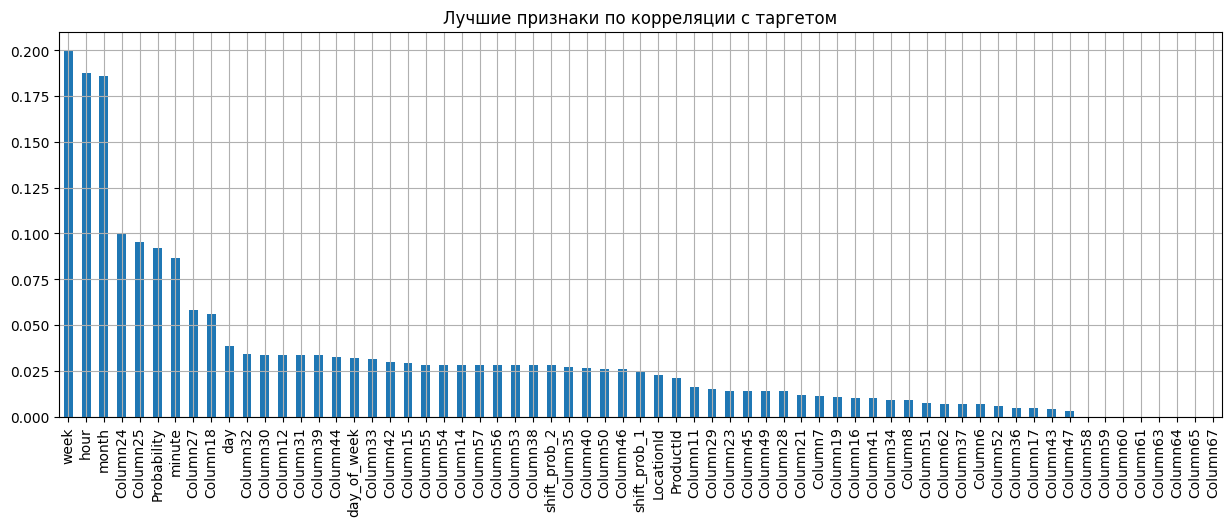

In [ ]:
plt.title('Лучшие признаки по корреляции с таргетом')
corr_with_target.plot.bar(figsize = (15, 5), grid=True);

In [ ]:
# Определим порог рандомной корреляции
X_train_.astype(float).fillna(0).sample(frac=1.0, random_state=10).reset_index(drop=True)\
                                        .corrwith(y_train).abs().sort_values(ascending=False)[:10]

Column33    0.005207
Column51    0.004644
Column18    0.004617
Column46    0.004483
Column50    0.004483
Column15    0.004401
Column38    0.004344
Column54    0.004344
Column55    0.004344
Column53    0.004344
dtype: float64

In [ ]:
corr_feats = corr_with_target > 0.005
X_train_ = X_train_.loc[:, corr_feats]
X_test_ = X_test_.loc[:, corr_feats]

## Обучение моделей

In [ ]:
CB_PARAMS = {'cat_features': model_feats,
             'iterations': 10000,
             'subsample': 0.7}

model = CatBoostClassifier(**CB_PARAMS,
                           random_state=RANDOM,
                           eval_metric='AUC',
                           early_stopping_rounds=300,
                           verbose=300
                           )

model.fit(X_train_, y_train, eval_set=[(X_test_, y_test)])

CB_PARAMS['iterations'] = model.best_iteration_
CB_PARAMS['learning_rate'] = model.get_all_params()['learning_rate']

Learning rate set to 0.037241
0:	test: 0.7261566	best: 0.7261566 (0)	total: 325ms	remaining: 54m 9s
300:	test: 0.8343969	best: 0.8343969 (300)	total: 49.9s	remaining: 26m 47s
600:	test: 0.8380589	best: 0.8381189 (596)	total: 1m 38s	remaining: 25m 36s
900:	test: 0.8386458	best: 0.8387760 (826)	total: 2m 27s	remaining: 24m 45s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8387760316
bestIteration = 826

Shrink model to first 827 iterations.


In [ ]:
y_pred = model.predict_proba(X_test_)[:, 1]
AUC_ROC = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, np.round(y_pred))
precision = precision_score(y_test, np.round(y_pred))
print(f'{AUC_ROC = :.3f}')
print(f'{precision = :.3f}')
print(f'{recall = :.3f}')

AUC_ROC = 0.839
precision = 0.827
recall = 0.692


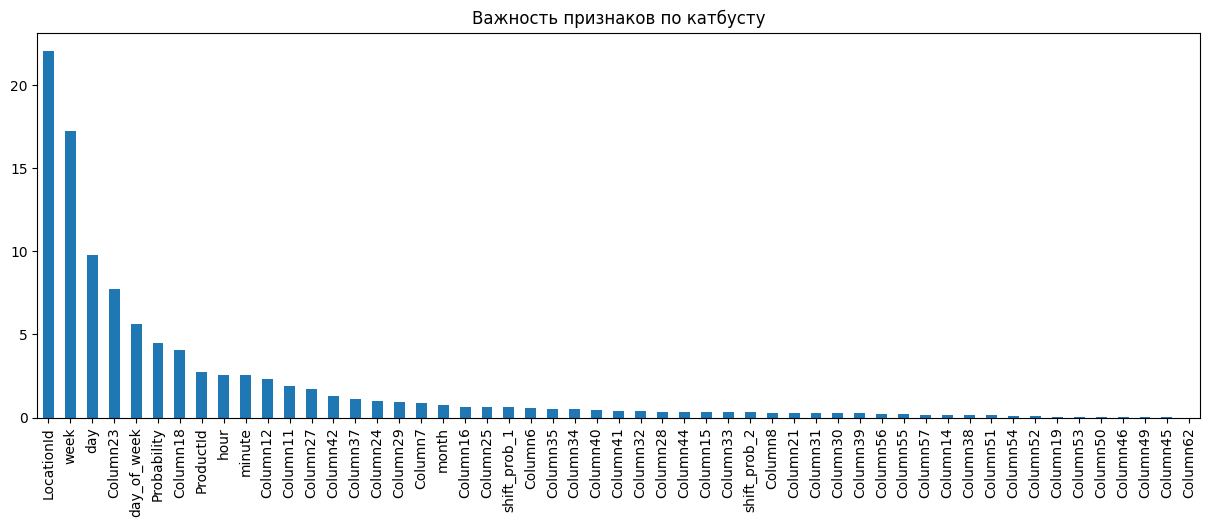

In [ ]:
# Построение важности признаков для модели CatBoost
plt.title('Важность признаков по катбусту')
pd.Series(np.sort(model.get_feature_importance())[::-1],
          index=X_train_.columns[model.get_feature_importance().argsort()[::-1]]).plot.bar(figsize=(15, 5));

In [ ]:
submit = X_test[['LocationId', 'ProductId', 'ValidationDateTime']].copy()
submit['CalculatedProbability'] = y_pred

# submit.to_csv('Команда№5_чек-пойнт№2.csv', sep=';', index=False)
submit.head()

,LocationId,ProductId,ValidationDateTime,CalculatedProbability
107777,2648,401972,2023-07-15 14:54:39.000,0.133499
107773,2648,401971,2023-07-15 14:55:00.033,0.110347
661,63,510528,2023-07-15 14:58:10.000,0.927155
66920,1719,523365,2023-07-15 14:58:10.000,0.915691
66605,1719,355836,2023-07-15 14:58:10.000,0.912421


In [ ]:
COUNT_randoms = 5
RANGE_randoms = 10000
np.random.seed(RANDOM)
RANDOM_STATES = np.random.randint(RANGE_randoms, size=COUNT_randoms)
preds = []
scores = []
cnt = 0

LGB_PARAMS = {'scale_pos_weight': 1.3,
              'n_estimators': 3000,
              'learning_rate': 0.01,
              'max_depth': 15,
              'num_leaves': 300
              }

XGB_PARAMS = {'scale_pos_weight': 0.3,
              'n_estimators': 3000,
              'learning_rate': 0.01,
              'max_depth': 7,
              'enable_categorical': True,
              'tree_method':'hist'
              }

for rs in RANDOM_STATES:
    cnt += 1

    mod_cb = CatBoostClassifier(**CB_PARAMS,
                                random_state=rs,
                                verbose=300
                                )

    mod_lgb = lgb.LGBMClassifier(**LGB_PARAMS,
                                 random_state=rs,
                                 force_row_wise=True
                                 )

    mod_xgb = xgb.XGBClassifier(**XGB_PARAMS,
                                random_state=rs
                                )

    mod_cb.fit(X_train_, y_train)
    mod_lgb.fit(X_train_, y_train)
    mod_xgb.fit(X_train_, y_train)

    pred = (mod_cb.predict_proba(X_test_)[:, 1]\
            + mod_lgb.predict_proba(X_test_)[:, 1]\
            + mod_xgb.predict_proba(X_test_)[:, 1]) / 3

    AUC_ROC_ = roc_auc_score(y_test, pred)

    print(f'>iter {cnt}, {AUC_ROC_ = :.3f}, {rs = }')
    scores.append(round(AUC_ROC_, 3))
    preds.append(pred)
    print()

y_pred = np.mean(preds, 0)
avg_iter_score = np.mean(scores)
std_iter_score = np.std(scores)

0:	learn: 0.6589565	total: 162ms	remaining: 2m 13s
300:	learn: 0.2691123	total: 47s	remaining: 1m 21s
600:	learn: 0.2547497	total: 1m 33s	remaining: 35.1s
825:	learn: 0.2476781	total: 2m 7s	remaining: 0us
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 18235, number of negative: 92677
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 110912, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164410 -> initscore=-1.625778
[LightGBM] [Info] Start training from score -1.625778
>iter 1, AUC_ROC_ = 0.843, rs = 4578

0:	learn: 0.6592229	total: 129ms	remaining: 1m 46s
300:	learn: 0.2705601	total: 46.8s	remaining: 1m 21s
600:	learn: 0.2552239	total: 1m 32s	remaining: 34.6s
825:	learn: 0.2483564	total: 2m 5s	

In [ ]:
AUC_ROC = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, np.round(y_pred))
recall = recall_score(y_test, np.round(y_pred))

print(f'{AUC_ROC = :.3f}, iter scores(std): {avg_iter_score:.3f}({std_iter_score:.3f}) {scores}')
print(f'{precision = :.3f}')
print(f'{recall = :.3f}')

AUC_ROC = 0.844, iter scores(std): 0.844(0.001) [0.843, 0.845, 0.843, 0.844, 0.843]
precision = 0.827
recall = 0.713
